# Setup

In [15]:
# install transformers package from Hugging Face transformers package contains 
# pre-trained BERT model and other useful interfaces
!pip install transformers 

In [16]:
# Check if Colab's GPU is available and set up the GPU device
import tensorflow as tf
import torch

device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('GPU is available')
else:
    raise SystemError('No GPU device available')

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name and type:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using CPU')
    device = torch.device("cpu")

GPU is available
GPU name and type: Tesla P100-PCIE-16GB


# Data Preprocessing

In [41]:
# dataset pre-processing
# load data_extraction.ipynb
import pandas as pd
import numpy as np

iamc_ds = pd.read_json('iamc.json')

# Testing with annotator02
tweets = np.array(list(iamc_ds['annotator02'][0]))
labels = np.array(list(iamc_ds['annotator02'][1]))

print('example 1')
print('tweet: ', tweets[0])
print('label: ', labels[0])

print('')
print('example 2')
print('tweet: ', tweets[1])
print('label: ', labels[1])


example 1
tweet:  Wholeheartedly support these protests ; acts of civil disobedience ; will join when I can! #Ferguson #AllLivesMatter 
label:  [0 0 0 1 0 0 0 0 0 0 0]

example 2
tweet:  This Sandra Bland situation man no disrespect rest her soul , but people die everyday in a unjustified matter #AllLivesMatter
label:  [0 0 0 0 0 1 0 0 0 0 0]


# Training Prep

### Input Tokenization & Encoding

In [37]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# visualize BERT tokenization by an example
print('Before:', tweets[0])
print('After(words):', tokenizer.tokenize(tweets[0]))
print('After(ids):', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

Loading BERT tokenizer...
Before: Wholeheartedly support these protests ; acts of civil disobedience ; will join when I can! #Ferguson #AllLivesMatter 
After(words): ['whole', '##hearted', '##ly', 'support', 'these', 'protests', ';', 'acts', 'of', 'civil', 'di', '##so', '##bed', '##ience', ';', 'will', 'join', 'when', 'i', 'can', '!', '#', 'ferguson', '#', 'all', '##li', '##ves', '##mat', '##ter']
After(ids): [2878, 27693, 2135, 2490, 2122, 8090, 1025, 4490, 1997, 2942, 4487, 6499, 8270, 13684, 1025, 2097, 3693, 2043, 1045, 2064, 999, 1001, 11262, 1001, 2035, 3669, 6961, 18900, 3334]


In [38]:
# Get the maximum length of the dataset since all input instances have to have a constant length
max_len = 0

for tweet in tweets:
    max_len = max(max_len, len(tweet.split()))

max_len += 2
print('Max tweet length:', max_len)


# tokenize all tweets, acquire corresponding token ids and attention masks
input_ids = []
attention_masks = []

for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(tweet, 
                                         add_special_tokens=True, 
                                         max_length=max_len,
                                         pad_to_max_length=True,
                                         return_attention_mask=True,
                                         return_tensors='pt'
                                         )
    

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels, dtype=torch.float)

# visualize tweet, tokenized ids and attention masks
print('Original tweet: ', tweets[0])
print('Token IDs:', input_ids[0])
print('Attention Mask:', attention_masks[0])
print('Labels:', labels[0])


AttributeError: ignored

### Training & Validation Split

In [20]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

dataset = TensorDataset(input_ids, attention_masks, labels)

# training 80% validation 10% testing 10%
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

print('training dataset size:', train_size)
print('validation dataset size:', val_size)
print('testing dataset size:', test_size)

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# create a dataloader
batch_size = 32

train_dl = DataLoader(train_ds, 
                      sampler=RandomSampler(train_ds), 
                      batch_size=batch_size)

val_dl = DataLoader(val_ds, 
                    sampler=SequentialSampler(val_ds), 
                    batch_size=batch_size)

test_dl = DataLoader(test_ds, 
                    sampler=SequentialSampler(test_ds), 
                    batch_size=batch_size)


training dataset size: 11582
validation dataset size: 1447
testing dataset size: 1449


### Building Multi-Label BERT Model

In [0]:
from transformers import BertModel, BertConfig, BertPreTrainedModel, BertForSequenceClassification
from torch.nn import BCEWithLogitsLoss

class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    """ 
    Bert for multi-label classification 
    """
    def __init__(self, config, num_labels=11):
        super(BertForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            new_loss = BCEWithLogitsLoss()
            loss = new_loss(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss, logits
        else:
            return logits

### Model Visualization

In [22]:
model = BertForMultiLabelSequenceClassification.from_pretrained("bert-base-uncased", 
                                                                 output_attentions=False, 
                                                                 output_hidden_states=False)

model.cuda()

#visualize
params = list(model.named_parameters())

for p in params:
    print("{:<60} {:>15}".format(p[0], str(tuple(p[1].size()))))


bert.embeddings.word_embeddings.weight                          (30522, 768)
bert.embeddings.position_embeddings.weight                        (512, 768)
bert.embeddings.token_type_embeddings.weight                        (2, 768)
bert.embeddings.LayerNorm.weight                                      (768,)
bert.embeddings.LayerNorm.bias                                        (768,)
bert.encoder.layer.0.attention.self.query.weight                  (768, 768)
bert.encoder.layer.0.attention.self.query.bias                        (768,)
bert.encoder.layer.0.attention.self.key.weight                    (768, 768)
bert.encoder.layer.0.attention.self.key.bias                          (768,)
bert.encoder.layer.0.attention.self.value.weight                  (768, 768)
bert.encoder.layer.0.attention.self.value.bias                        (768,)
bert.encoder.layer.0.attention.output.dense.weight                (768, 768)
bert.encoder.layer.0.attention.output.dense.bias                      (768,)

### Optimizer & Learning Rate Scheduler

In [0]:
from transformers import get_linear_schedule_with_warmup, AdamW

# set up the optimizer
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8)

# set up the lr scheduler
epochs = 3
total_steps = len(train_dl) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

### Helper Functions

In [0]:
import time
import datetime
from sklearn.metrics import hamming_loss

def get_accuracy_hamming_loss(preds, labels):
    preds = preds >= 0
    
    total = []
    for i in range(len(preds)):
        total.append(1 - hamming_loss(preds[i],labels[i]))

    return np.mean(total)
                
# calculate accuracy
def get_accuracy(preds, labels):
    preds = preds >= 0
    
    total = []
    for i in range(len(preds)):
        suM = 0
        for j in range(len(preds[i])):
            correct = 0
            #correct
            if preds[i][j] == 1 and labels[i][j]== 1 :
                suM += 1
                correct += 1
            #missed 
            elif labels[i][j]== 1 and preds[i][j] == 0:
                suM += 1
            elif labels[i][j]== 0 and preds[i][j] == 1:
                suM += 1
        total.append(correct/suM)

    return np.mean(total)
                
    # return np.mean(np.array(preds) == np.array(labels))


# take a time in seconds and returns a string hh:mm:ss
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))


# Training

In [34]:
import random

seed_val = 1
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time() 

# initialize BERT weights
model.init_weights()

for epoch_i in range(0, epochs):
    print("")
    print('======= Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print("")

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dl):
        # periodically update elapsed time
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, 
                                                                 len(train_dl), 
                                                                 elapsed))
        # unpack current batch's input & labels   
        cur_input_ids = batch[0].to(device)
        cur_input_mask = batch[1].to(device)
        cur_labels = batch[2].to(device)

        # clear previously calculated gradients
        model.zero_grad()

        # perform a forward pass
        # logits = classifications, before activation function e.x. softmax
        loss, logits = model(cur_input_ids, 
                             token_type_ids=None,
                             attention_mask=cur_input_mask,
                             labels=cur_labels)
        
        # accumulate training loss
        total_train_loss += loss.item()

        # perform a backward pass to calculate the gradients of params
        loss.backward()

        # clip the gradients if it is not in [-1,1]
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update weights
        optimizer.step()

        # update lr
        scheduler.step()

    # calculate stats after 1 epoch of training
    avg_train_loss = total_train_loss / len(train_dl)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # validation 
    print("")
    print("Validating...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dl:
        
        # unpack current batch's input and labels
        cur_input_ids = batch[0].to(device)
        cur_input_mask = batch[1].to(device)
        cur_labels = batch[2].to(device)

        # no need to calculate and trace gradient
        with torch.no_grad():
            loss, logits = model(cur_input_ids,
                                   token_type_ids=None,
                                   attention_mask=cur_input_mask,
                                   labels=cur_labels)
                    
        # no need to calculate prediction & labels in gpu
        # good practice when involves with large-scale dataset
        logits = logits.detach().cpu().numpy()
        label_ids = cur_labels.to('cpu')
        
        # calculate this batch's accuracy & loss and accumulate with other 
        # batches' accuracies & loss
        total_eval_accuracy += get_accuracy(logits, label_ids)
        total_eval_loss += loss.item()

    # average out loss and accuracy across all batches
    avg_val_accuracy = total_eval_accuracy / len(val_dl)
    avg_val_loss = total_eval_loss / len(val_dl)
    validation_time = format_time(time.time() - t0)

    print(
        "Average Accuracy: {0:}, Loss: {1:.2f}, Time elapsed: {2:}".format(
            avg_val_accuracy, avg_val_loss, validation_time
        )
    )

    # record all statistics for this epoch
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })


print("")
print("Training Completed. Training took {:}".format(format_time(time.time() - total_t0)))



======= Epoch 1 / 3 ========

Batch    40 of   362. Elapsed: 0:00:05.
Batch    80 of   362. Elapsed: 0:00:11.
Batch   120 of   362. Elapsed: 0:00:16.
Batch   160 of   362. Elapsed: 0:00:22.
Batch   200 of   362. Elapsed: 0:00:27.
Batch   240 of   362. Elapsed: 0:00:32.
Batch   280 of   362. Elapsed: 0:00:38.
Batch   320 of   362. Elapsed: 0:00:43.
Batch   360 of   362. Elapsed: 0:00:49.

  Average training loss: 0.29
  Training epcoh took: 0:00:49

Validating...
Average Accuracy: 0.9124258893280632, Loss: 0.25, Time elapsed: 0:00:02

======= Epoch 2 / 3 ========

Batch    40 of   362. Elapsed: 0:00:05.
Batch    80 of   362. Elapsed: 0:00:11.
Batch   120 of   362. Elapsed: 0:00:16.
Batch   160 of   362. Elapsed: 0:00:22.
Batch   200 of   362. Elapsed: 0:00:27.
Batch   240 of   362. Elapsed: 0:00:32.
Batch   280 of   362. Elapsed: 0:00:38.
Batch   320 of   362. Elapsed: 0:00:43.
Batch   360 of   362. Elapsed: 0:00:49.

  Average training loss: 0.26
  Training epcoh took: 0:00:49

Valida

In [26]:
# Display training stats
# Display numbers with two decimal
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur,Training Time,Validation Time
epoch,,,,,
1,0.29,0.25,0.61,0:00:48,0:00:02
2,0.26,0.24,0.62,0:00:48,0:00:02
3,0.25,0.23,0.56,0:00:48,0:00:02
4,0.23,0.23,0.53,0:00:48,0:00:02
5,0.21,0.22,0.57,0:00:48,0:00:02


ERROR! Session/line number was not unique in database. History logging moved to new session 62


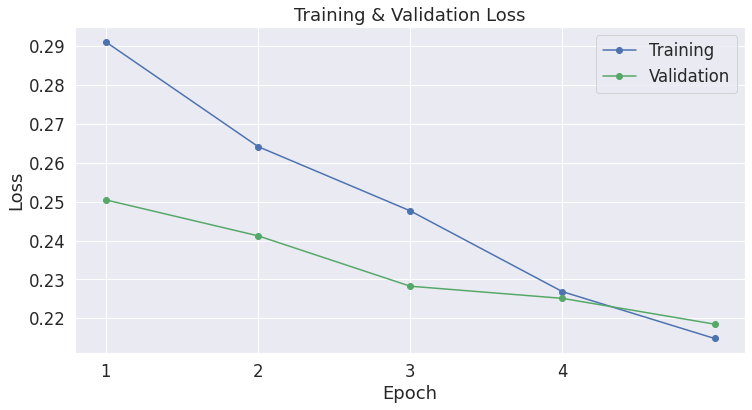

In [28]:
# Visualize training stats
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### TO_DO: change epoch number
plt.xticks([1,2,3,4])

plt.show()

# Testing

In [31]:
print('Predicting labels for {:,} test sentences...'.format(len(test_dl)) * batch_size)

model.eval()

total_accuracy_test = 0

for batch in test_dl:
    # add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    cur_input_ids, cur_input_mask, cur_labels = batch

    with torch.no_grad():
        loss, logits = model(cur_input_ids, 
                        token_type_ids=None, 
                        attention_mask=cur_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = cur_labels.to('cpu').numpy()

    total_accuracy_test += get_accuracy(logits, label_ids)

print('Testing Accuracy: {:.2f}'.format(total_accuracy_test/len(test_dl)))
print('Testing Completed')


### TO-DO: ROC-AUC curve -- good metric
# https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sentences...Predicting labels for 46 test sent

ValueError: ignored

# Conclusion